In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib. pyplot as plt
from tqdm import trange
import math

In [2]:
# ================================================================
# Coordinate → Fourier features
# ================================================================
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim=2, mapping_size=64, scale=10.0):
        super().__init__()
        self.register_buffer('B', torch.randn(input_dim, mapping_size) * scale)

    def forward(self, coords):                               # (B,H,W,2)
        proj = 2 * math.pi * torch.matmul(coords, self.B)    # (B,H,W,mapping_size)
        ff   = torch.cat([torch.cos(proj), torch.sin(proj)], dim=-1)
        return ff.permute(0, 3, 1, 2)                        # (B,2*mapping_size,H,W)

# ---------------------------------------------------------------
def get_coord_grid(batch, h, w, device):
    xs = torch.linspace(0, 1, w, device=device)
    ys = torch.linspace(0, 1, h, device=device)
    gy, gx = torch.meshgrid(ys, xs, indexing='ij')
    grid = torch.stack((gx, gy), dim=-1).unsqueeze(0).repeat(batch, 1, 1, 1)
    return grid                                              # (B,H,W,2)

# ================================================================
# Fourier Neural Operator 2-D spectral layer
# ================================================================
class FourierLayer(nn.Module):
    def __init__(self, in_ch, out_ch, modes1, modes2):
        super().__init__()
        self.modes1, self.modes2 = modes1, modes2
        self.weight = nn.Parameter(
            torch.randn(in_ch, out_ch, modes1, modes2, dtype=torch.cfloat)
            / (in_ch * out_ch)
        )

    @staticmethod
    def compl_mul2d(inp, w):                                 # (B,IC,H,W) × (IC,OC,H,W)
        return torch.einsum('bixy,ioxy->boxy', inp, w)

    def forward(self, x):                                    # (B,C,H,W)  real
        B, _, H, W = x.shape
        x_ft = torch.fft.rfft2(x)

        m1 = min(self.modes1, H)
        m2 = min(self.modes2, x_ft.size(-1))                 # W_freq = W//2+1

        out_ft = torch.zeros(
            B, self.weight.size(1), H, x_ft.size(-1),
            dtype=torch.cfloat, device=x.device
        )
        out_ft[:, :, :m1, :m2] = self.compl_mul2d(
            x_ft[:, :, :m1, :m2],
            self.weight[:, :, :m1, :m2]
        )
        return torch.fft.irfft2(out_ft, s=x.shape[-2:])

# ---------------------------------------------------------------
class ConvBlock(nn.Module):
    """[Conv → GELU] × 2 (keeps H×W)."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GELU()
        )
    def forward(self, x): return self.block(x)

# ================================================================
# ↓↓↓ PixelShuffle-based up-sample block ↓↓↓
# ================================================================
class PixelShuffleUpsample(nn.Module):
    def __init__(self, in_ch, out_ch, upscale=2):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * (upscale ** 2), 3, padding=1)
        self.pix  = nn.PixelShuffle(upscale)
        self.act  = nn.GELU()
    def forward(self, x):
        return self.act(self.pix(self.conv(x)))

# ================================================================
# U-Net with Fourier bottleneck + PixelShuffle up-sampling
# NOTE: -- No pooling inside the bottleneck (only in encoder) --
# ================================================================
class SuperResUNet(nn.Module):
    def __init__(
        self,
        in_channels=101,
        lift_dim=128,
        mapping_size=64,
        mapping_scale=5.0,
        final_scale=2        # ← auto-detected from data
    ):
        super().__init__()

        # -------- lift ---------------
        self.fourier_mapping = FourierFeatureMapping(2, mapping_size, mapping_scale)
        lifted_ch = in_channels + 2 * mapping_size
        self.lift = nn.Conv2d(lifted_ch, lift_dim, kernel_size=1)

        # -------- encoder ------------
        self.enc1 = ConvBlock(lift_dim,        lift_dim)        # keep  (Hc)
        self.enc2 = ConvBlock(lift_dim,        lift_dim * 2)    # pool → (Hc/2)
        self.pool = nn.MaxPool2d(2)

        # -------- bottleneck ---------
    
        self.bottleneck = nn.Sequential(
            ConvBlock(lift_dim * 2, lift_dim * 2),
            FourierLayer(lift_dim * 2, lift_dim * 2, modes1=32, modes2=32),
            nn.GELU()
        )

        # -------- decoder ------------
        # up1 keeps spatial dims (upscale=1) so it matches e2
        self.up1  = PixelShuffleUpsample(lift_dim * 2, lift_dim * 2, upscale=1)
        self.dec2 = ConvBlock(lift_dim * 4, lift_dim)                    # cat(up1,e2)

        self.up2  = PixelShuffleUpsample(lift_dim, lift_dim)             # ×2  (Hc/2 → Hc)
        self.dec1 = ConvBlock(lift_dim * 2, lift_dim // 2)               # cat(up2,e1)

        self.dec0 = nn.Sequential(                                       # Hc → Hc×final_scale
            PixelShuffleUpsample(lift_dim // 2, lift_dim // 4, upscale=final_scale),
            ConvBlock(lift_dim // 4, lift_dim // 4)
        )

        # -------- output head --------
        self.out_head = nn.Sequential(
            nn.Conv2d(lift_dim // 4, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, in_channels, 3, padding=1)                      # 11-channel output
        )

    # -----------------------------------------------------------
    def forward(self, x):                                 # (B,11,Hc,Wc) normalised
        B, _, H, W = x.shape
        coords = get_coord_grid(B, H, W, x.device)
        x = torch.cat([x, self.fourier_mapping(coords)], dim=1)   # lift
        x = self.lift(x)

        e1 = self.enc1(x)               # Hc
        e2 = self.enc2(self.pool(e1))   # Hc/2

        # ---- bottleneck ----
        b  = self.bottleneck(e2)        # Hc/2

        # ---- decoder ----
        d2 = self.up1(b)                             # Hc/2  (spatially matches e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up2(d2)                            # Hc
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        d0 = self.dec0(d1)                           # Hf
        return self.out_head(d0)                     # (B,11,Hf,Wf)  normalised
# import torch.nn.functional as F

# # ------------------------------------------------------------------
# # (Assume `FourierFeatureMapping` and `get_coord_grid`
# #  are defined elsewhere in your codebase.)
# # ------------------------------------------------------------------

# # ================================================================
# # Blur-pool down-sampling (antialiased)
# # ================================================================
# class BlurPool2d(nn.Module):
#     """
#     Depth-wise 3×3 Gaussian blur followed by 2× average-pool.
#     Keeps the number of channels unchanged and halves H, W.
#     """
#     def __init__(self, channels: int):
#         super().__init__()
#         k = torch.tensor([1., 2., 1.])           #  [1 2 1]^T [1 2 1]
#         kernel = (k[:, None] * k[None, :]).float()
#         kernel /= kernel.sum()                   # normalise
#         self.register_buffer(
#             "weight",
#             kernel[None, None, :, :].repeat(channels, 1, 1, 1)  # (C,1,3,3)
#         )

#     def forward(self, x):                       # (B,C,H,W) → (B,C,H/2,W/2)
#         x = F.pad(x, (1, 1, 1, 1), mode="reflect")
#         x = F.conv2d(x, self.weight, stride=1, groups=x.shape[1])
#         return F.avg_pool2d(x, kernel_size=2, stride=2)


# # ================================================================
# # Fourier Neural Operator 2-D spectral layer
# # ================================================================
# class FourierLayer(nn.Module):
#     def __init__(self, in_ch, out_ch, modes1, modes2):
#         super().__init__()
#         self.modes1, self.modes2 = modes1, modes2
#         self.weight = nn.Parameter(
#             torch.randn(in_ch, out_ch, modes1, modes2, dtype=torch.cfloat)
#             / (in_ch * out_ch)
#         )

#     @staticmethod
#     def compl_mul2d(inp, w):
#         return torch.einsum("bixy,ioxy->boxy", inp, w)

#     def forward(self, x):
#         B, _, H, W = x.shape
#         x_ft = torch.fft.rfft2(x)
#         m1, m2 = min(self.modes1, H), min(self.modes2, x_ft.size(-1))
#         out_ft = torch.zeros(
#             B, self.weight.size(1), H, x_ft.size(-1),
#             dtype=torch.cfloat, device=x.device
#         )
#         out_ft[:, :, :m1, :m2] = self.compl_mul2d(
#             x_ft[:, :, :m1, :m2], self.weight[:, :, :m1, :m2]
#         )
#         return torch.fft.irfft2(out_ft, s=x.shape[-2:])


# # ================================================================
# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.GELU(),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.GELU(),
#         )

#     def forward(self, x):
#         return self.block(x)


# # ================================================================
# class PixelShuffleUpsample(nn.Module):
#     def __init__(self, in_ch, out_ch, upscale=2):
#         super().__init__()
#         self.conv = nn.Conv2d(in_ch, out_ch * (upscale ** 2), 3, padding=1)
#         self.pix = nn.PixelShuffle(upscale)
#         self.act = nn.GELU()

#     def forward(self, x):
#         return self.act(self.pix(self.conv(x)))


# # ================================================================
# # Helper for HANO-style multi-scale feature aggregation
# # ================================================================
# class ToFine(nn.Module):
#     def __init__(self, in_ch, out_ch, up_factor: int):
#         super().__init__()
#         self.up = nn.Upsample(scale_factor=up_factor,
#                               mode="bilinear", align_corners=False)
#         self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1)

#     def forward(self, x):
#         return self.proj(self.up(x))


# # ================================================================
# class SuperResUNet(nn.Module):
#     """
#     FUnet + HANO-style multi-scale fusion with antialiased blur-pool
#     down-sampling in the encoder.
#     """
#     def __init__(
#         self,
#         in_channels: int = 101,
#         lift_dim: int = 128,
#         mapping_size: int = 64,
#         mapping_scale: float = 5.0,
#         final_scale: int = 2,
#     ):
#         super().__init__()

#         # Fourier positional encoding & lift
#         self.fourier_mapping = FourierFeatureMapping(2, mapping_size, mapping_scale)
#         lifted_ch = in_channels + 2 * mapping_size
#         self.lift = nn.Conv2d(lifted_ch, lift_dim, kernel_size=1)

#         # Encoder
#         self.enc1 = ConvBlock(lift_dim, lift_dim)
#         self.pool = BlurPool2d(lift_dim)               # ← replaces MaxPool2d
#         self.enc2 = ConvBlock(lift_dim, lift_dim * 2)

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             ConvBlock(lift_dim * 2, lift_dim * 2),
#             FourierLayer(lift_dim * 2, lift_dim * 2, modes1=32, modes2=32),
#             nn.GELU(),
#         )

#         # Decoder
#         self.up1 = PixelShuffleUpsample(lift_dim * 2, lift_dim * 2, upscale=1)
#         self.dec2 = ConvBlock(lift_dim * 4, lift_dim)

#         self.up2 = PixelShuffleUpsample(lift_dim, lift_dim)      # ×2
#         self.dec1 = ConvBlock(lift_dim * 2, lift_dim // 2)

#         self.dec0 = nn.Sequential(
#             PixelShuffleUpsample(lift_dim // 2, lift_dim // 4, upscale=final_scale),
#             ConvBlock(lift_dim // 4, lift_dim // 4),
#         )

#         # HANO-style fusion
#         agg_ch = lift_dim // 4
#         self.tofine_e1 = ToFine(lift_dim,        agg_ch, up_factor=final_scale)
#         self.tofine_e2 = ToFine(lift_dim * 2,    agg_ch, up_factor=2 * final_scale)
#         self.tofine_b  = ToFine(lift_dim * 2,    agg_ch, up_factor=2 * final_scale)
#         self.tofine_d1 = ToFine(lift_dim // 2,   agg_ch, up_factor=final_scale)

#         # Output head
#         self.out_head = nn.Sequential(
#             nn.Conv2d(agg_ch, 32, 3, padding=1),
#             nn.GELU(),
#             nn.Conv2d(32, in_channels, 3, padding=1),
#         )

#     # ------------------------------------------------------------
#     def forward(self, x):
#         B, _, H, W = x.shape

#         # positional encoding
#         coords = get_coord_grid(B, H, W, x.device)
#         x = torch.cat([x, self.fourier_mapping(coords)], dim=1)
#         x = self.lift(x)

#         # encoder
#         e1 = self.enc1(x)                    # (B, D, H,   W)
#         e2 = self.enc2(self.pool(e1))        # (B, 2D, H/2, W/2)

#         # bottleneck
#         b = self.bottleneck(e2)              # (B, 2D, H/2, W/2)

#         # decoder
#         d2 = self.dec2(torch.cat([self.up1(b), e2], dim=1))      # (B, D,   H/2, W/2)
#         d1 = self.dec1(torch.cat([self.up2(d2), e1], dim=1))     # (B, D/2, H,   W)
#         d0 = self.dec0(d1)                                       # (B, D/4, 2H,  2W)

#         # HANO-style “sum of all levels” fusion
#         fine = (
#             d0
#             + self.tofine_e1(e1)
#             + self.tofine_e2(e2)
#             + self.tofine_b(b)
#             + self.tofine_d1(d1)
#         )

#         return self.out_head(fine)

In [5]:
# ----------------------------
# Evaluation: Iterative Future Extrapolation with AB3 on the Coarse Grid
# ----------------------------

device = 'cpu'#torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Initialize models and load saved weights
model = SuperResUNet(final_scale=4).to(device)
model.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/2d_wave_FUnet_best_v1_medium_sf=4.pth'))#['model_state_dict'])
model.eval()

SuperResUNet(
  (fourier_mapping): FourierFeatureMapping()
  (lift): Conv2d(229, 128, kernel_size=(1, 1), stride=(1, 1))
  (enc1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
    )
  )
  (enc2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GELU(approximate='none')
        (2): Conv2d(256, 256

In [8]:
# # Load full trajectory sample 
# idx = 0
# input_data, output_data = load_single_sample_full(idx)
input_CG = np.load(f"/pscratch/sd/h/hbassi/wave_dataset_multi_sf_modes=10_kmax=7/u_coarse_sf={4}_test.npy")[:, :101]
target_FG =  np.load("/pscratch/sd/h/hbassi/wave_dataset_multi_sf_modes=10_kmax=7/u_fine_test.npy")[:, :101]
input_data, output_data = torch.tensor(input_CG), torch.tensor(target_FG)
input_data.shape, output_data.shape

(torch.Size([1000, 101, 32, 32]), torch.Size([1000, 101, 128, 128]))

In [5]:
# Normalize stats
stats = torch.load('./data/2d_wave_funet_phase1_stats_32to128_v1_medium.pt', map_location=device)
data_mean = stats['data_mean'].squeeze(0)
data_std  = stats['data_std'].squeeze(0)

In [6]:
with torch.no_grad():
    pred = model((input_data.float().to(device)  - data_mean) / data_std).squeeze(0)
    pred  = pred * data_std + data_mean

In [7]:
pred = pred.cpu().detach()

In [8]:
from scipy.ndimage import zoom
# ---------- automatic sizes ----------
N, Nt, Nc, _ = input_data.shape     # (N, Nt, 128, 128)
Nf           = output_data.shape[2] # 256
scale        = Nf / Nc              # 2.0

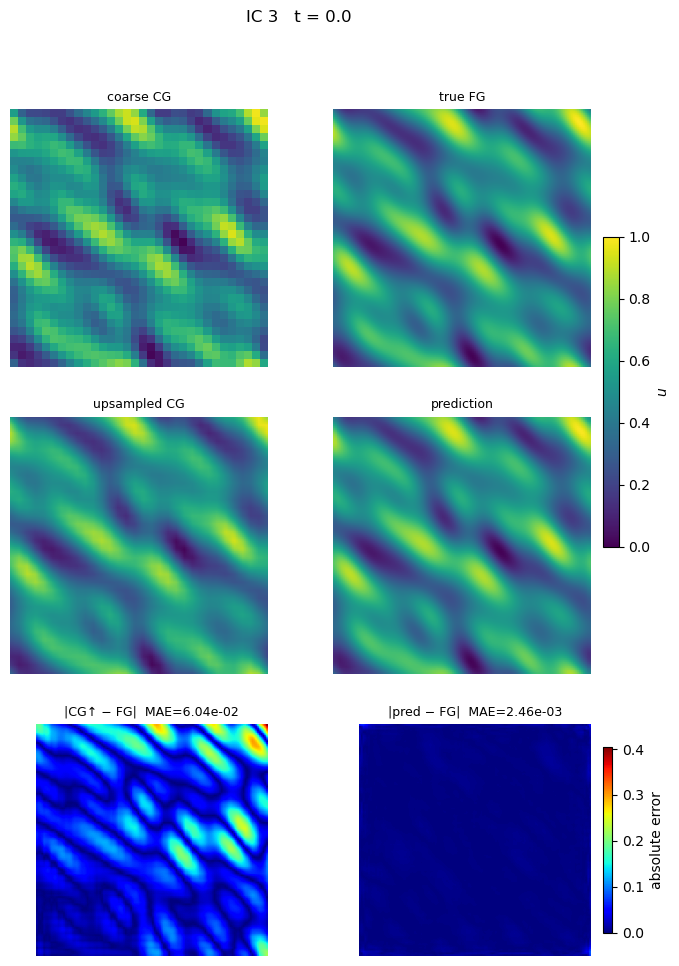

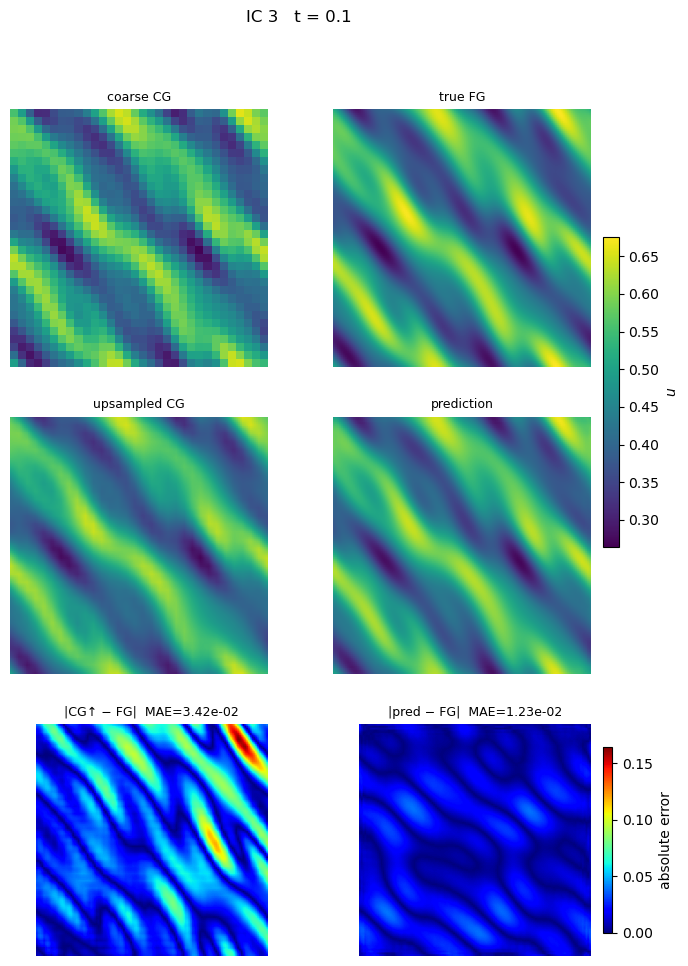

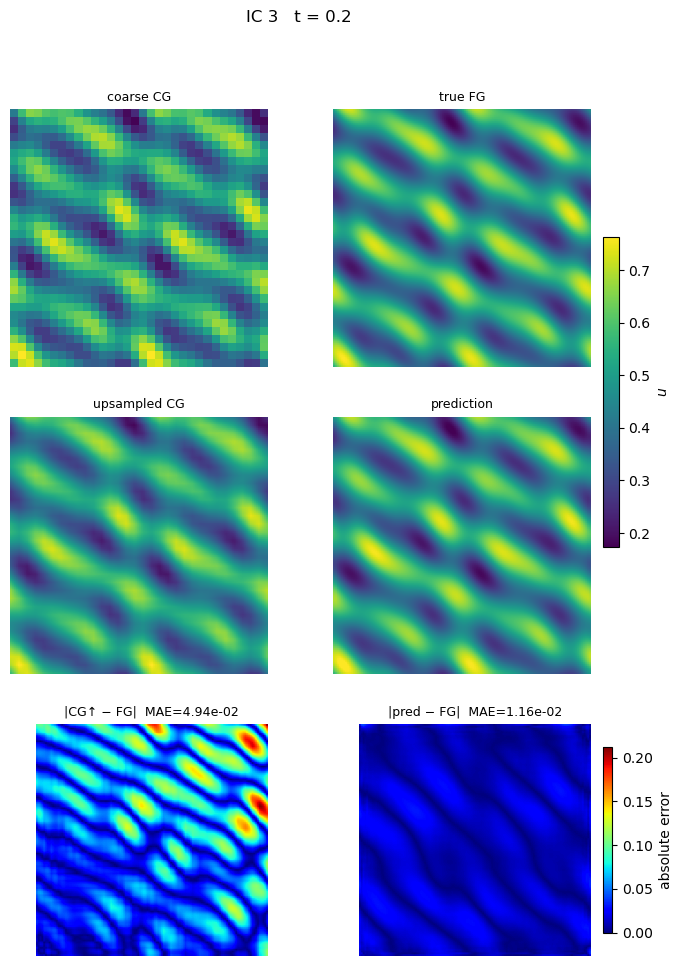

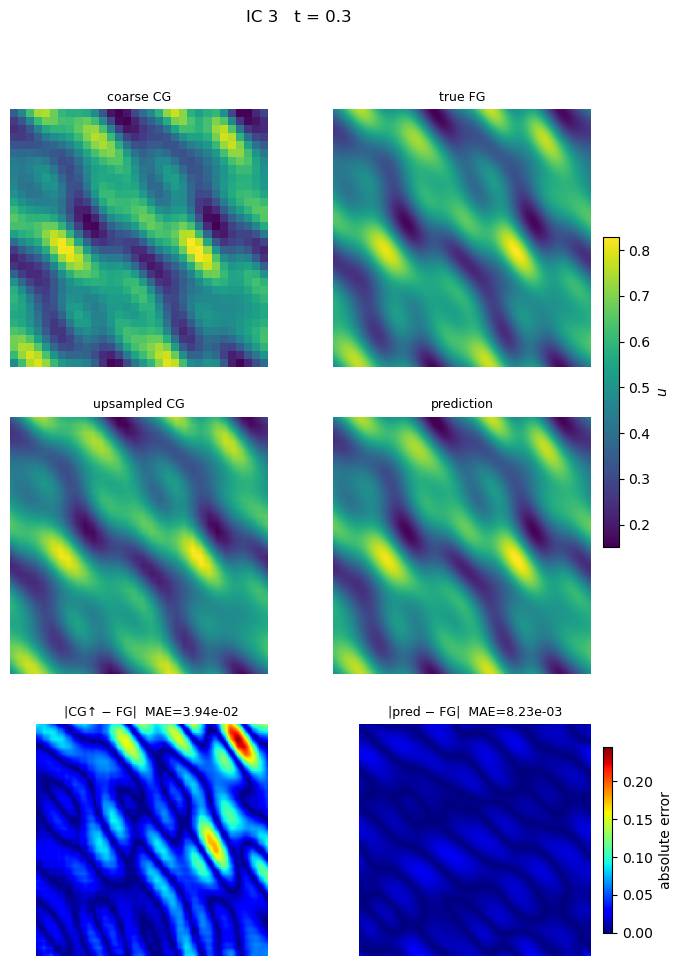

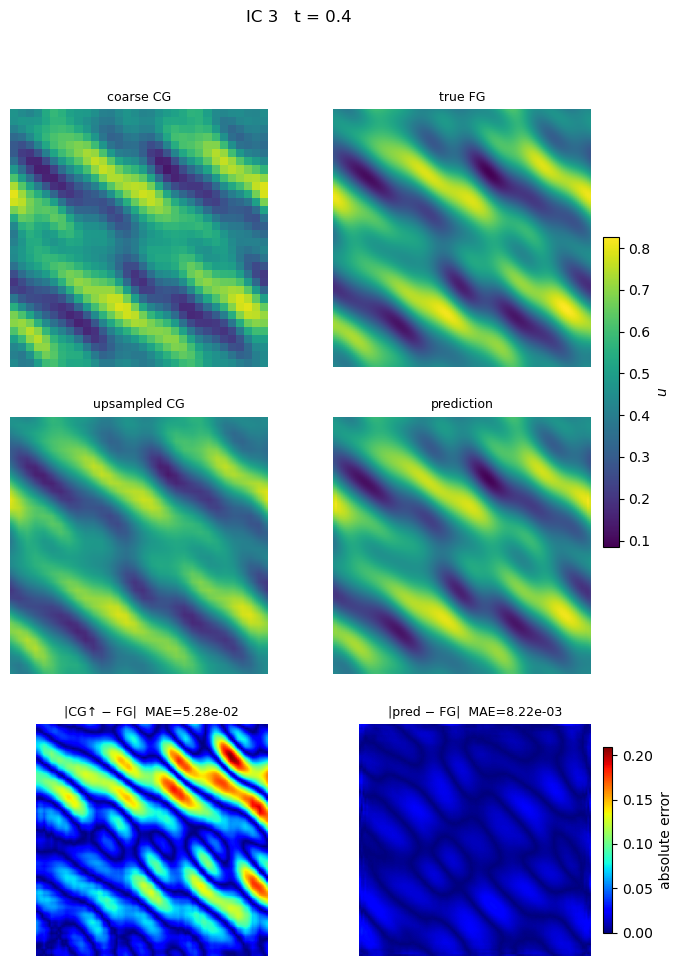

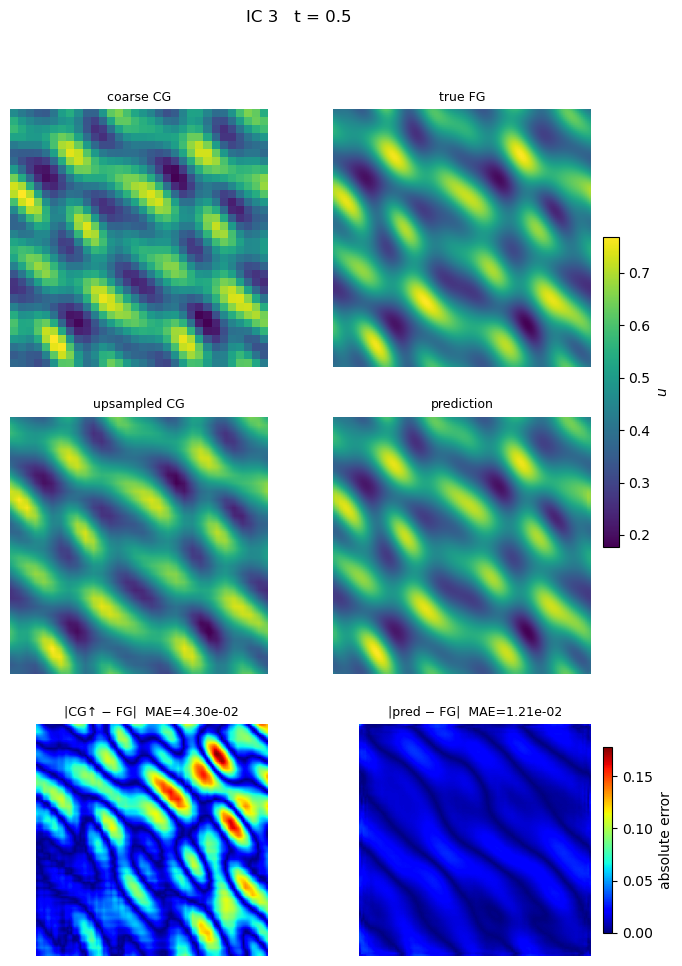

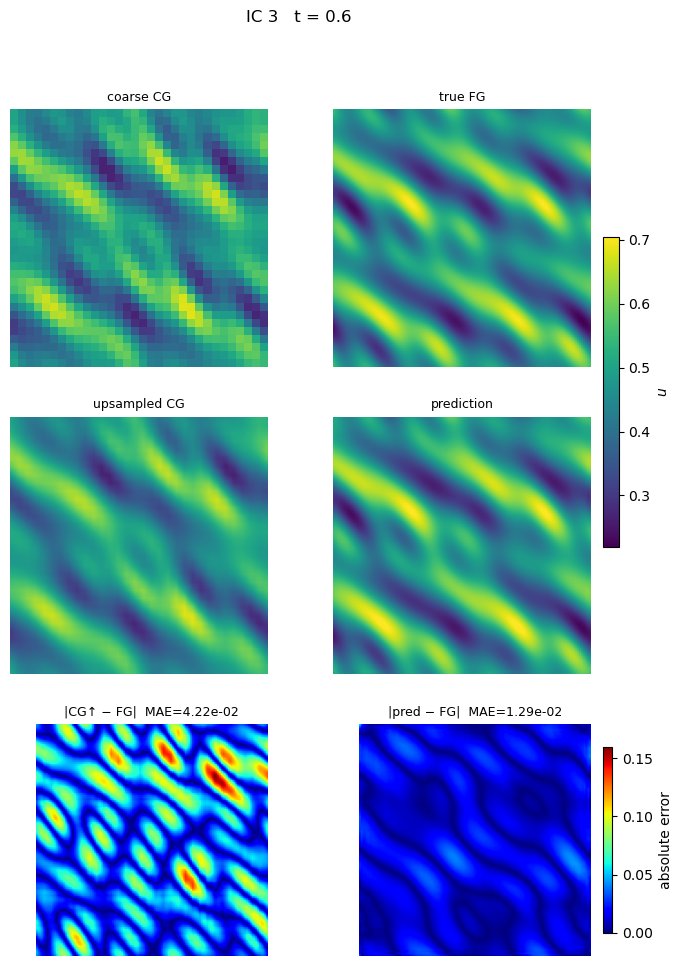

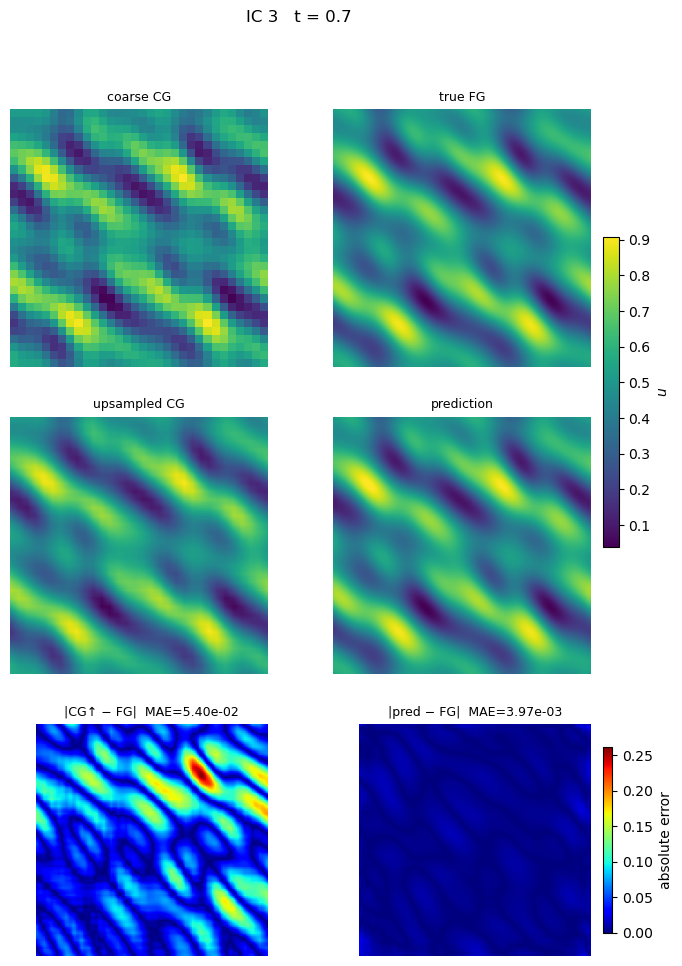

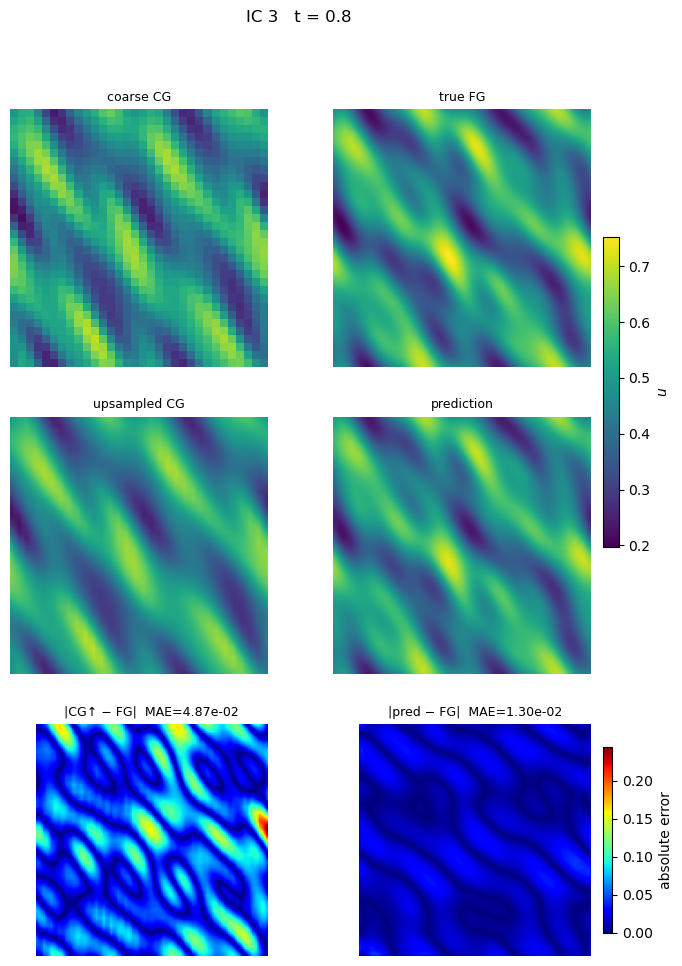

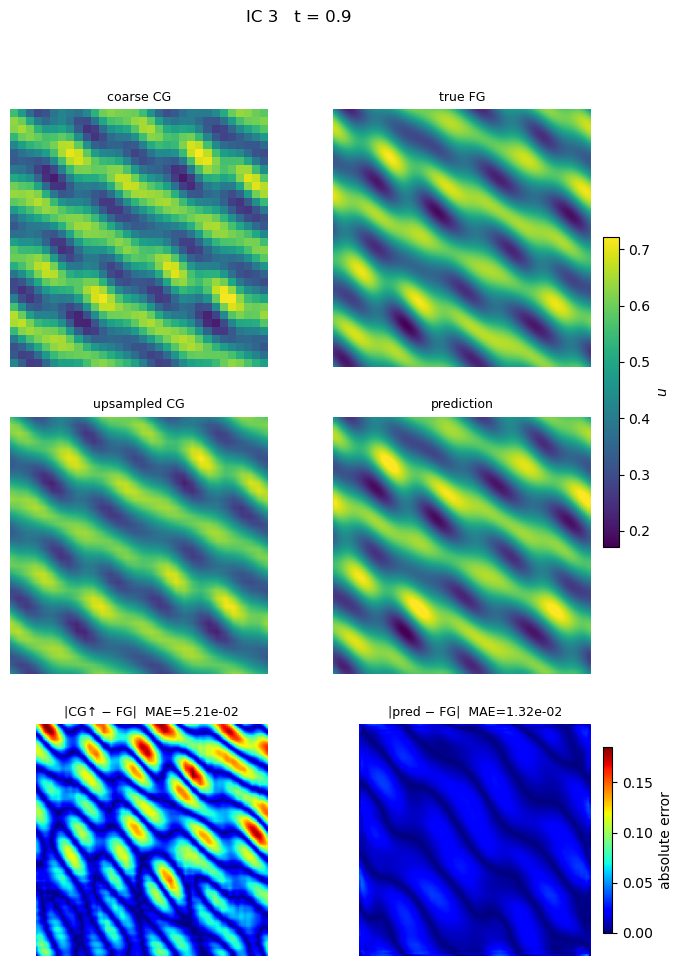

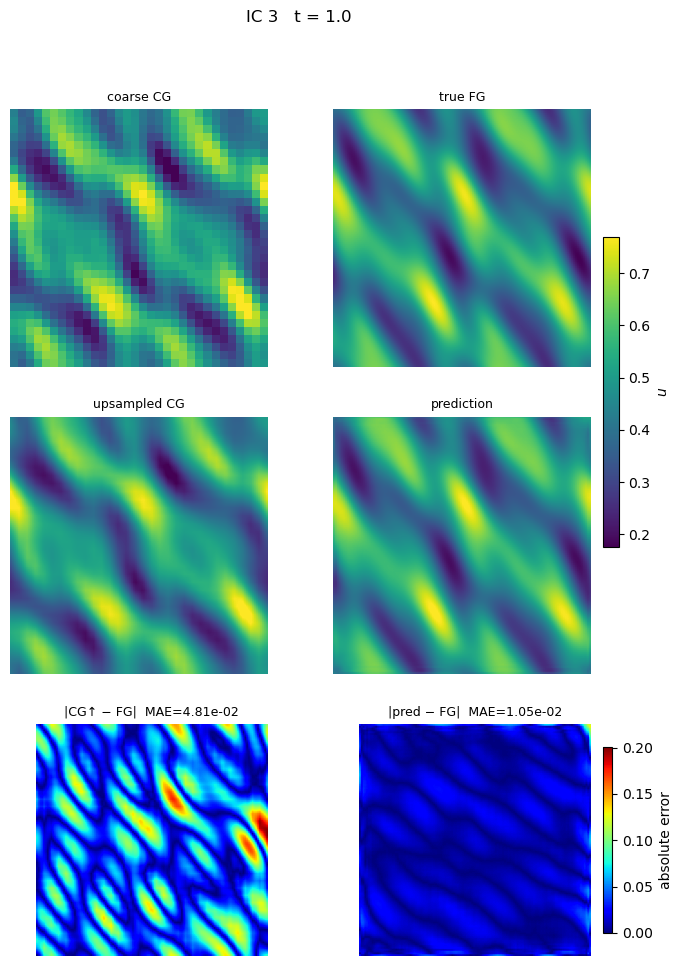

In [9]:
from scipy.ndimage import zoom

# … (same setup as before) …
case_list = [3]
for case in case_list:
    for t in range(0, Nt, 10):

        # --- data & up-sampling -----------------------------------------
        rho_cg   = input_data[case, t]                                    # numpy 128×128
        rho_up   = zoom(rho_cg, scale, order=1)                          # numpy 256×256
        rho_pred = pred[case, t].cpu().detach().numpy()                  # convert to numpy
        rho_fine = output_data[case, t].cpu().detach().numpy()           # convert to numpy

        # --- common scale for the first-row images ----------------------
        vmin = rho_fine.min()#min(rho_cg.min(), rho_up.min(), rho_pred.min(), rho_fine.min())
        vmax = rho_fine.max()#max(rho_cg.max(), rho_up.max(), rho_pred.max(), rho_fine.max())

        # --- error maps & common scale ----------------------------------
        err_up   = np.abs(rho_up   - rho_fine)
        err_pred = np.abs(rho_pred - rho_fine)
        err_max  = max(err_up.max(), err_pred.max())

        # --- compute MAE for annotations ---------------------------------
        mae_up   = err_up.mean()        # now a numpy array
        mae_pred = err_pred.mean()      # also numpy

                # --- figure with 3 rows × 2 columns -----------------------------------
        fig, axes = plt.subplots(
            3, 2, figsize=(8, 11),
            gridspec_kw={'height_ratios': [1, 1, 0.9]},
            sharex=False, sharey=False
        )
        
        # -------- rows 1–2 : solution fields ----------------------------------
        field_panels = [
            (rho_cg,  "coarse CG"),          # row 1, col 1
            (rho_fine, "true FG"),           # row 1, col 2
            (rho_up,  "upsampled CG"),       # row 2, col 1
            (rho_pred, "prediction")         # row 2, col 2
        ]
        for ax, (img, ttl) in zip(axes[:2, :].ravel(), field_panels):
            h_field = ax.imshow(img, origin='lower', vmin=vmin, vmax=vmax)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')
        
        fig.colorbar(
            h_field,
            ax=axes[:2, :].ravel().tolist(),  # both rows of field axes
            orientation='vertical',
            fraction=0.025, pad=0.02, shrink=0.8,
            label=r"$u$"
        )
        
        # -------- row 3 : absolute-error maps ---------------------------------
        err_panels = [
            (err_up,   f"|CG↑ − FG|  MAE={mae_up:.2e}"),
            (err_pred, f"|pred − FG|  MAE={mae_pred:.2e}")
        ]
        for ax, (img, ttl) in zip(axes[2], err_panels):
            h_err = ax.imshow(img, origin='lower', cmap='jet',
                              vmin=0, vmax=err_max)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')
        
        fig.colorbar(
            h_err,
            ax=axes[2].tolist(),             # the error-map row
            orientation='vertical',
            fraction=0.025, pad=0.02, shrink=0.8,
            label='absolute error'
        )
        
        fig.suptitle(f"IC {case}   t = {round(t * 0.01, 2)}", y=0.97, fontsize=12)
        # plt.tight_layout()  
        # plt.savefig(f'./figures/wave/funet/low_freq/'
        #             f'2d_wave_sep_evo_smooth_ic_low_freq_modes=20_funet_phase1_'
        #             f'test_fe_ic={case}_t={t}.pdf')
        plt.show()


In [10]:
eps = 1e-8  # to avoid division by zero in relative MSE

case_list    = range(0, 20)           # 20 indices: 0 … 19
time_indices = list(range(0, Nt))     # evaluate every time step

n_cases = len(case_list)
n_times = len(time_indices)

# ↓↓↓ store **relative mean-squared errors** ↓↓↓
rmse_up_all   = np.zeros((n_cases, n_times), dtype=np.float64)
rmse_pred_all = np.zeros((n_cases, n_times), dtype=np.float64)

for i, case in enumerate(case_list):
    for j, t in enumerate(time_indices):
        # --- coarse-grid slice (already NumPy) ----------------------------
        rho_cg = input_data[case, t]            

        # --- bicubic up-sample to fine resolution ------------------------
        rho_up = zoom(rho_cg, scale, order=3)   

        # --- model prediction & ground truth -----------------------------
        rho_pred = pred[case, t].cpu().numpy()
        rho_fine = output_data[case, t].cpu().numpy()

        # --- relative mean-squared errors --------------------------------
        mse_up   = ((rho_up   - rho_fine) ** 2).mean()
        mse_pred = ((rho_pred - rho_fine) ** 2).mean()
        denom    = (rho_fine ** 2).mean() + eps   # normaliser

        rmse_up_all  [i, j] = mse_up   / denom
        rmse_pred_all[i, j] = mse_pred / denom

# ------------------------------------------------------------------------
# Overall average relative MSE (all cases × all times)
overall_rmse_up   = rmse_up_all.mean()
overall_rmse_pred = rmse_pred_all.mean()

print(f"Overall relative MSE of bicubic CG↑ vs. FG: {overall_rmse_up:.3e}")
print(f"Overall relative MSE of prediction vs. FG:  {overall_rmse_pred:.3e}")

# Per-case averages (mean over time for each case)
per_case_rmse_up   = rmse_up_all.mean(axis=1)     # shape (20,)
per_case_rmse_pred = rmse_pred_all.mean(axis=1)   # shape (20,)

for c in range(n_cases):
    print(f"Case {c:2d}  →  RMSE_up = {per_case_rmse_up[c]:.3e},   "
          f"RMSE_pred = {per_case_rmse_pred[c]:.3e}")

Overall relative MSE of bicubic CG↑ vs. FG: 1.736e-02
Overall relative MSE of prediction vs. FG:  2.180e-03
Case  0  →  RMSE_up = 1.328e-02,   RMSE_pred = 1.945e-03
Case  1  →  RMSE_up = 3.394e-02,   RMSE_pred = 3.334e-04
Case  2  →  RMSE_up = 1.646e-02,   RMSE_pred = 5.908e-03
Case  3  →  RMSE_up = 1.534e-02,   RMSE_pred = 6.978e-04
Case  4  →  RMSE_up = 1.467e-02,   RMSE_pred = 2.100e-04
Case  5  →  RMSE_up = 2.242e-02,   RMSE_pred = 2.827e-04
Case  6  →  RMSE_up = 6.551e-03,   RMSE_pred = 7.771e-03
Case  7  →  RMSE_up = 2.520e-02,   RMSE_pred = 5.304e-04
Case  8  →  RMSE_up = 1.243e-02,   RMSE_pred = 8.368e-03
Case  9  →  RMSE_up = 1.825e-02,   RMSE_pred = 1.012e-03
Case 10  →  RMSE_up = 7.659e-03,   RMSE_pred = 7.520e-03
Case 11  →  RMSE_up = 1.287e-02,   RMSE_pred = 1.764e-03
Case 12  →  RMSE_up = 3.040e-02,   RMSE_pred = 2.269e-04
Case 13  →  RMSE_up = 1.054e-02,   RMSE_pred = 9.593e-04
Case 14  →  RMSE_up = 1.522e-02,   RMSE_pred = 9.580e-04
Case 15  →  RMSE_up = 8.492e-03,   RM